### Redes Neurais Recorrentes
Prevendo as ações da petrobrás no intervalo de 7 meses


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os.path


In [ ]:

base = pd.read_csv("PETR4.SA.csv")

In [ ]:
base = base.dropna()
base_treinamento = base.iloc[:,1:2].values 
normalizador = MinMaxScaler(feature_range=(0,1))
#base_treinamento_normalizada = base_treinamento
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_treinamento_normalizada.size

In [ ]:
previsores = []
classe = []
#Cria um série temporal de 7 meses da coluna Open
for i in range(7,base_treinamento_normalizada.size):
  previsores.append(base_treinamento_normalizada[i-7:i,0])
  classe.append(base_treinamento_normalizada[i,0])
previsores,classe = np.array(previsores), np.array(classe) #transforma as colunas em número
previsores = np.reshape(previsores,(previsores.shape[0],previsores.shape[1],1)) #reduz para a coluna Open
previsores.shape


In [ ]:
def redeNeuralRecorrente(prev,cl):
    regressor = Sequential()
    regressor.add(LSTM(units=100 , return_sequences=True, input_shape = (prev.shape[1],1)))
    regressor.add(Dropout(0.3))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.3))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.3))
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.3))
    regressor.add(Dense(units=1,activation='sigmoid'))
    if os.path.isfile('pesosRedeNeuralRecorrente.h5'):
        regressor.load_weights('pesosRedeNeuralRecorrente.h5') 
    regressor.compile(optimizer = 'rmsprop', loss ='mean_squared_error', metrics = ['mean_absolute_error'])
    eas = EarlyStopping(monitor='loss',min_delta=2e-05,patience=10,verbose=1)#Se passarem 10 épocas, e não houver uma mudança mínima de 2e-05, ele para.
    rlc = ReduceLROnPlateau(monitor = 'mean_absolute_error', factor = 0.1,patience=2,verbose=1)#Reduz learning rate em 0.1, se não houver mudanças na loss function
    mcp = ModelCheckpoint(filepath='pesosRedeNeuralRecorrente.h5',monitor='mean_absolute_error',save_best_only=True)
    regressor.fit(prev,cl,epochs = 100, batch_size = 41,callbacks=[eas,rlc,mcp])
    return regressor

In [ ]:
kfold = KFold(n_splits=10)

cvscores = []

for train, test in kfold.split(previsores, classe):
  regressor = redeNeuralRecorrente(previsores[train], classe[train])
  scores = regressor.evaluate(previsores[test], classe[test], verbose=0)
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores),  np.std(cvscores)))

In [ ]:
x_teste = [5.338000,	5.363000,5.325000,5.313000,5.200000,5.163000,5.163000] #5.225000
x_teste = np.array(x_teste)
x_teste = x_teste.reshape(-1,1)
x_teste = normalizador.transform(x_teste)
x_teste = x_teste.reshape(1, 7, 1)
previsao = regressor.predict(x_teste)
previsao = normalizador.inverse_transform(previsao)
previsao[0][0]-0.06

5.266987266540528

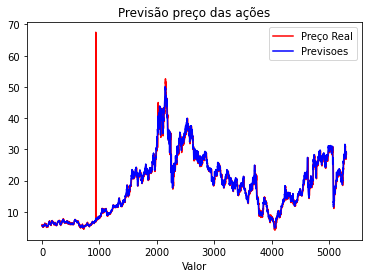

In [ ]:
plt.plot(base.iloc[:,1:2].values, color = 'red', label = 'Preço Real')
plt.plot(previsoes, color = 'blue', label = 'Previsoes')
plt.title('Previsão preço das ações')
plt.xlabel('tempo')
plt.xlabel('Valor')
plt.legend()
plt.show()